In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pymc
from lmfit import Model
import lmfit
from scipy import interpolate, convolve
import scipy.signal as signal
import glob
import os, sys
import astropy.io.fits as fits
import multiprocessing
import os
import pyspeckit
import scipy.optimize as op
import corner

7443/12703


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,75 [pyspeckit.spectrum.interactive]


divide by zero encountered in log


 [-----------------100%-----------------] 5000 of 5000 complete in 33.3 sec

using a non-integer number instead of an integer will result in an error in the future


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,75 [pyspeckit.spectrum.interactive]


divide by zero encountered in log


 [-----------------100%-----------------] 5000 of 5000 complete in 34.1 sec

using a non-integer number instead of an integer will result in an error in the future


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,75 [pyspeckit.spectrum.interactive]


 [-----------------100%-----------------] 5000 of 5000 complete in 20.5 sec

using a non-integer number instead of an integer will result in an error in the future


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,75 [pyspeckit.spectrum.interactive]


divide by zero encountered in log


 [-----------------100%-----------------] 5000 of 5000 complete in 33.8 sec

using a non-integer number instead of an integer will result in an error in the future


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,75 [pyspeckit.spectrum.interactive]
 [-----------------100%-----------------] 5000 of 5000 complete in 31.2 sec

using a non-integer number instead of an integer will result in an error in the future


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,75 [pyspeckit.spectrum.interactive]
 [-----------------100%-----------------] 5000 of 5000 complete in 30.9 sec

using a non-integer number instead of an integer will result in an error in the future


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,75 [pyspeckit.spectrum.interactive]


divide by zero encountered in log


 [-----------------100%-----------------] 5000 of 5000 complete in 42.1 sec

using a non-integer number instead of an integer will result in an error in the future


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,75 [pyspeckit.spectrum.interactive]


divide by zero encountered in log


 [-----------------100%-----------------] 5000 of 5000 complete in 34.8 sec

using a non-integer number instead of an integer will result in an error in the future


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,75 [pyspeckit.spectrum.interactive]


divide by zero encountered in log


 [-----------------100%-----------------] 5000 of 5000 complete in 36.0 sec

using a non-integer number instead of an integer will result in an error in the future


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,75 [pyspeckit.spectrum.interactive]
 [-----------------100%-----------------] 5000 of 5000 complete in 31.4 sec

using a non-integer number instead of an integer will result in an error in the future
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,75 [pyspeckit.spectrum.interactive]


divide by zero encountered in log


 [-----------------100%-----------------] 5000 of 5000 complete in 34.1 sec

using a non-integer number instead of an integer will result in an error in the future
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,75 [pyspeckit.spectrum.interactive]


divide by zero encountered in log


 [-----------------100%-----------------] 5000 of 5000 complete in 33.5 sec

using a non-integer number instead of an integer will result in an error in the future
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


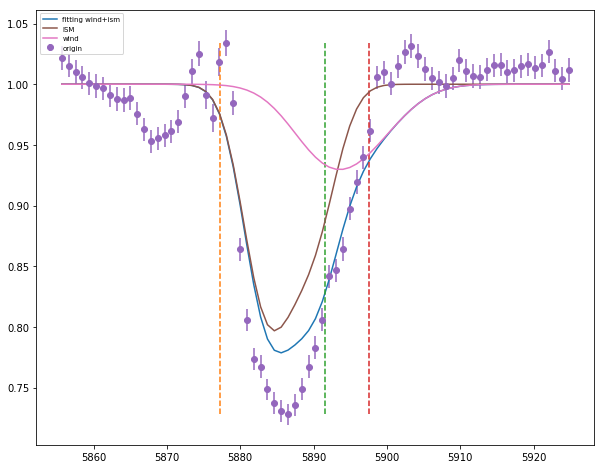

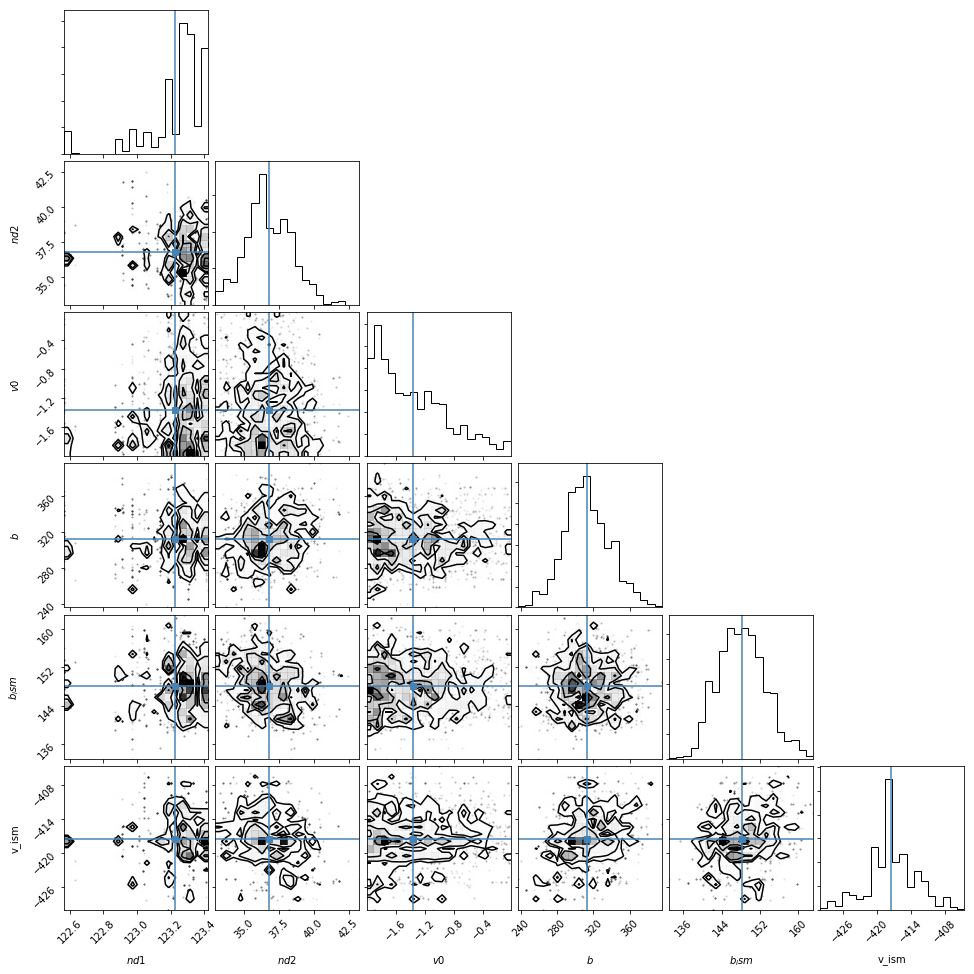

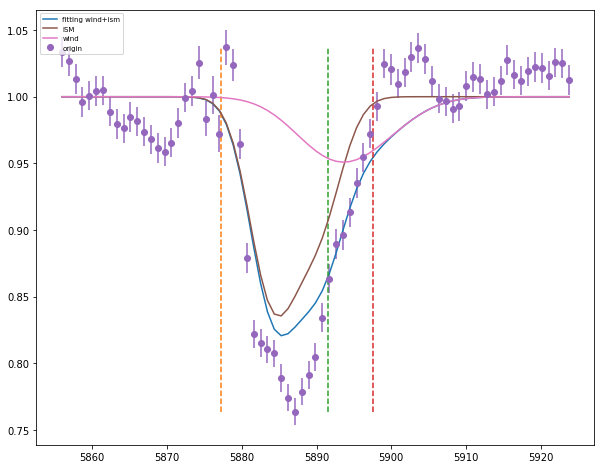

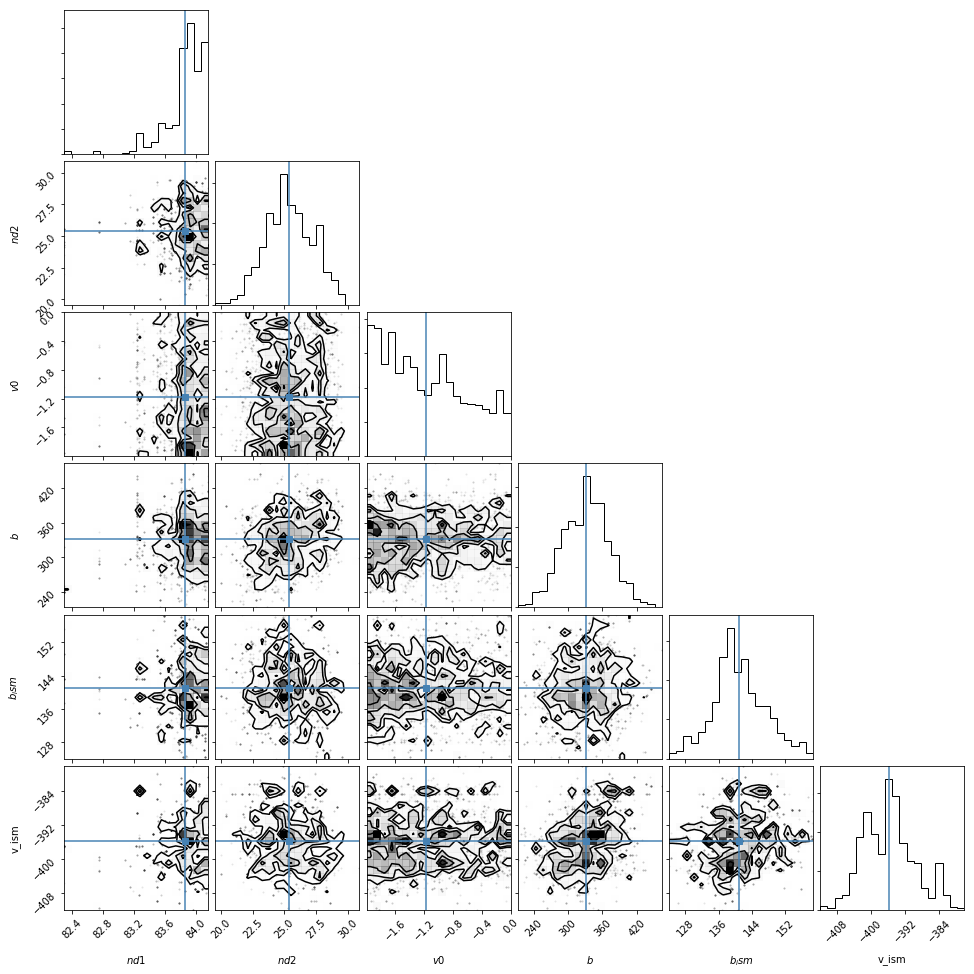

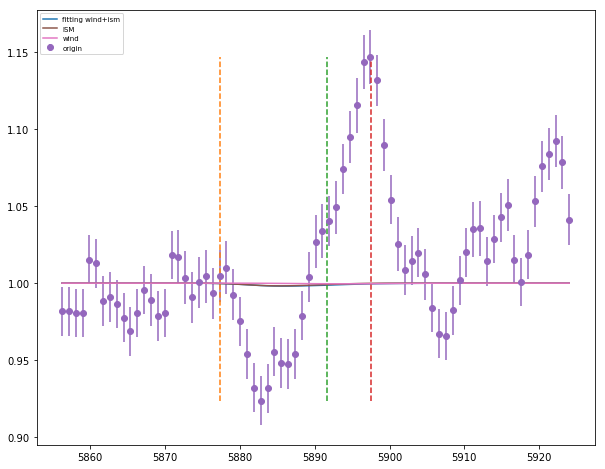

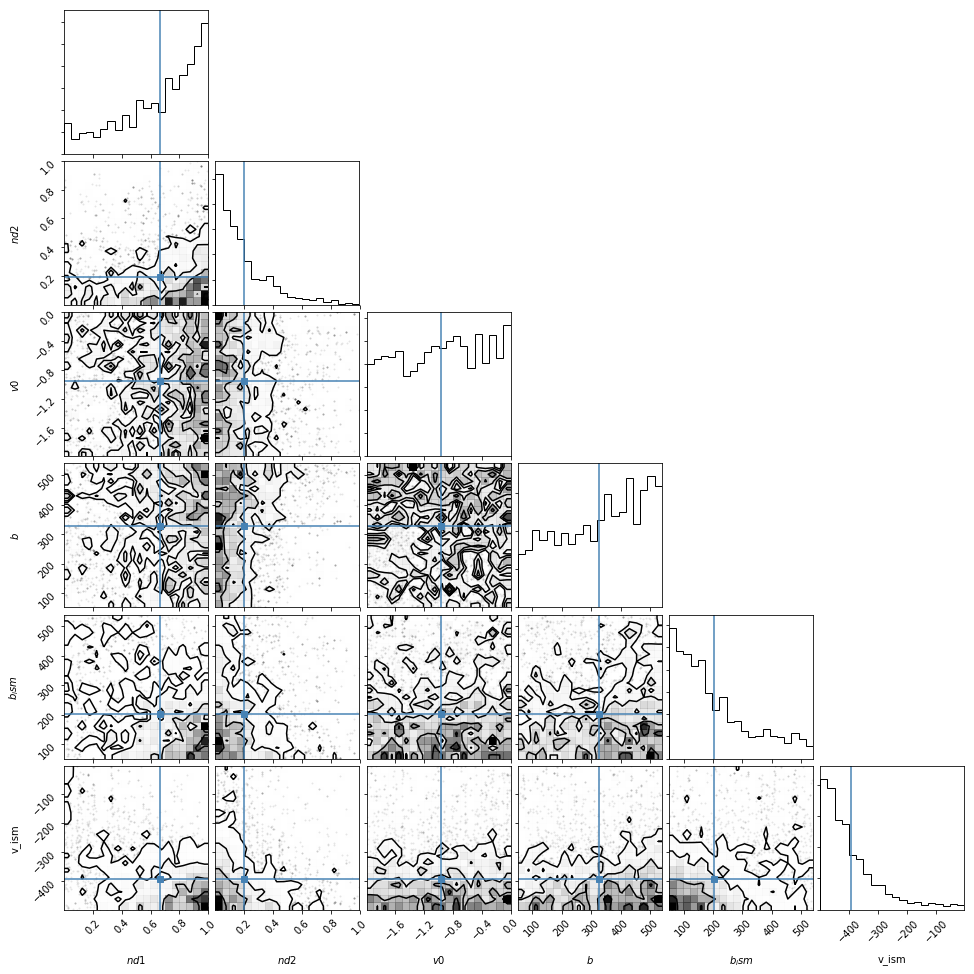

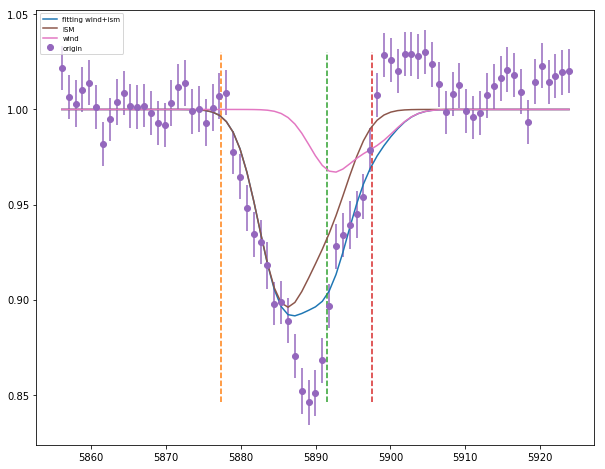

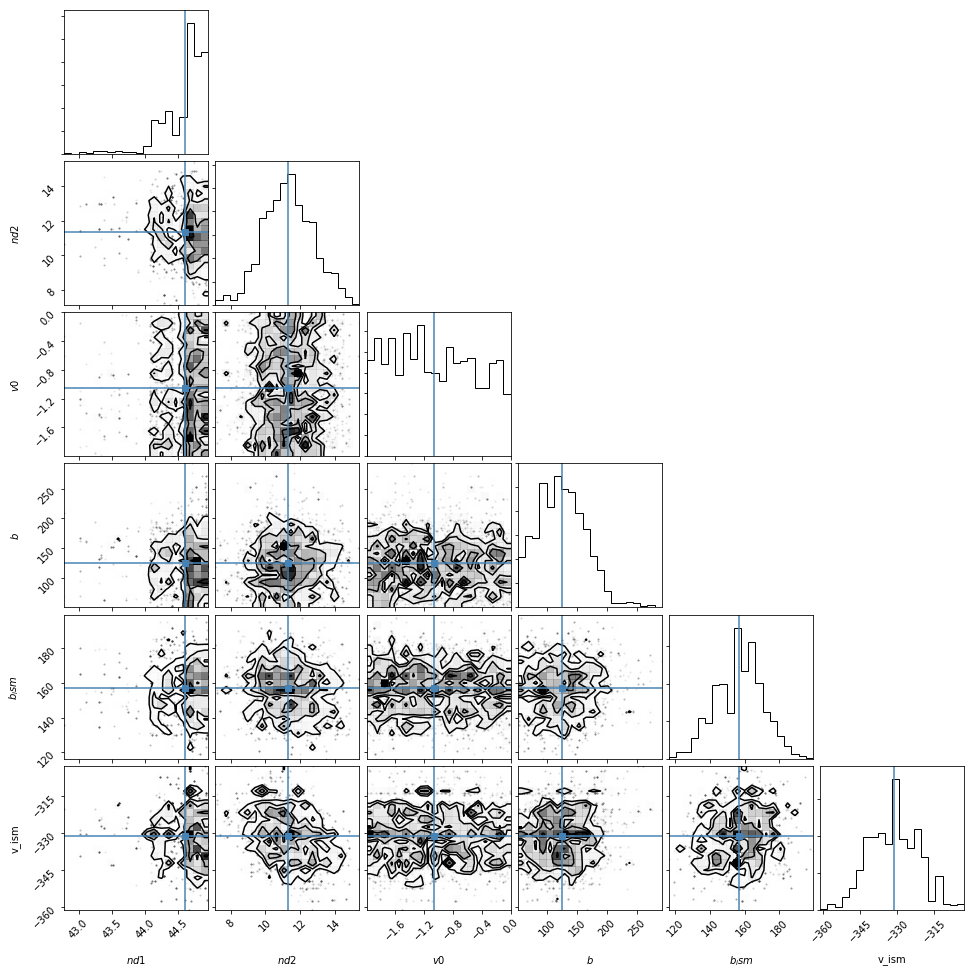

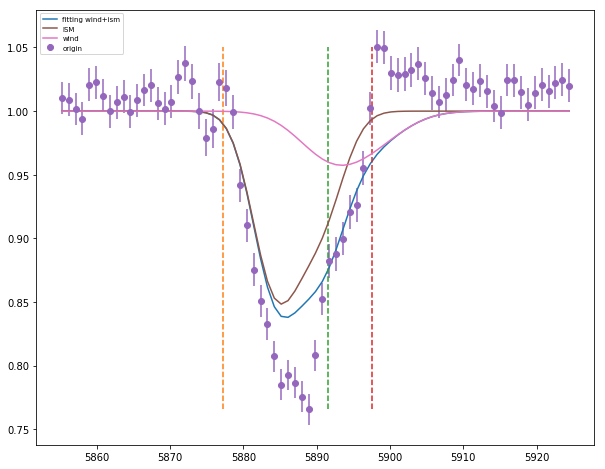

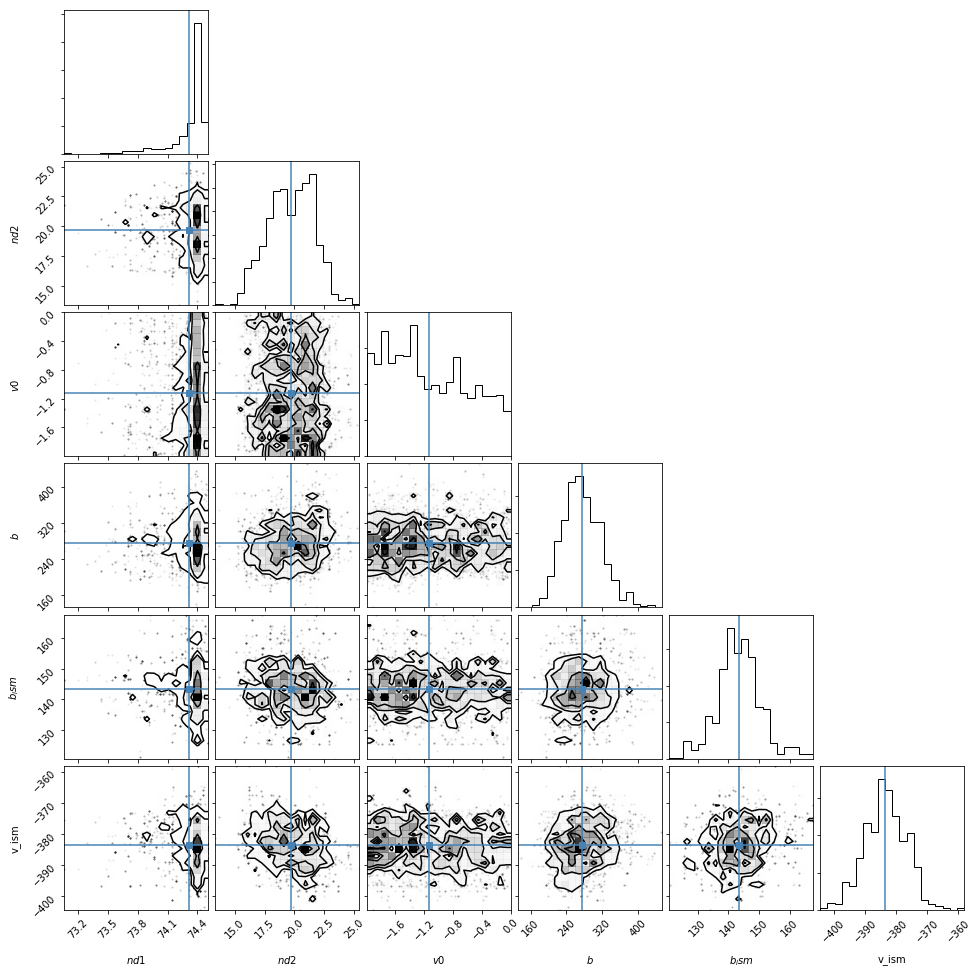

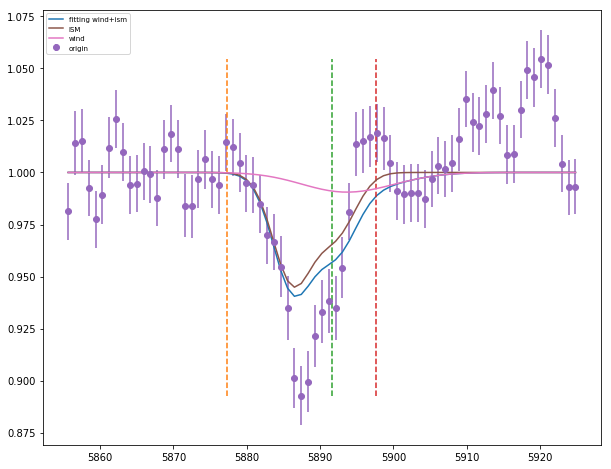

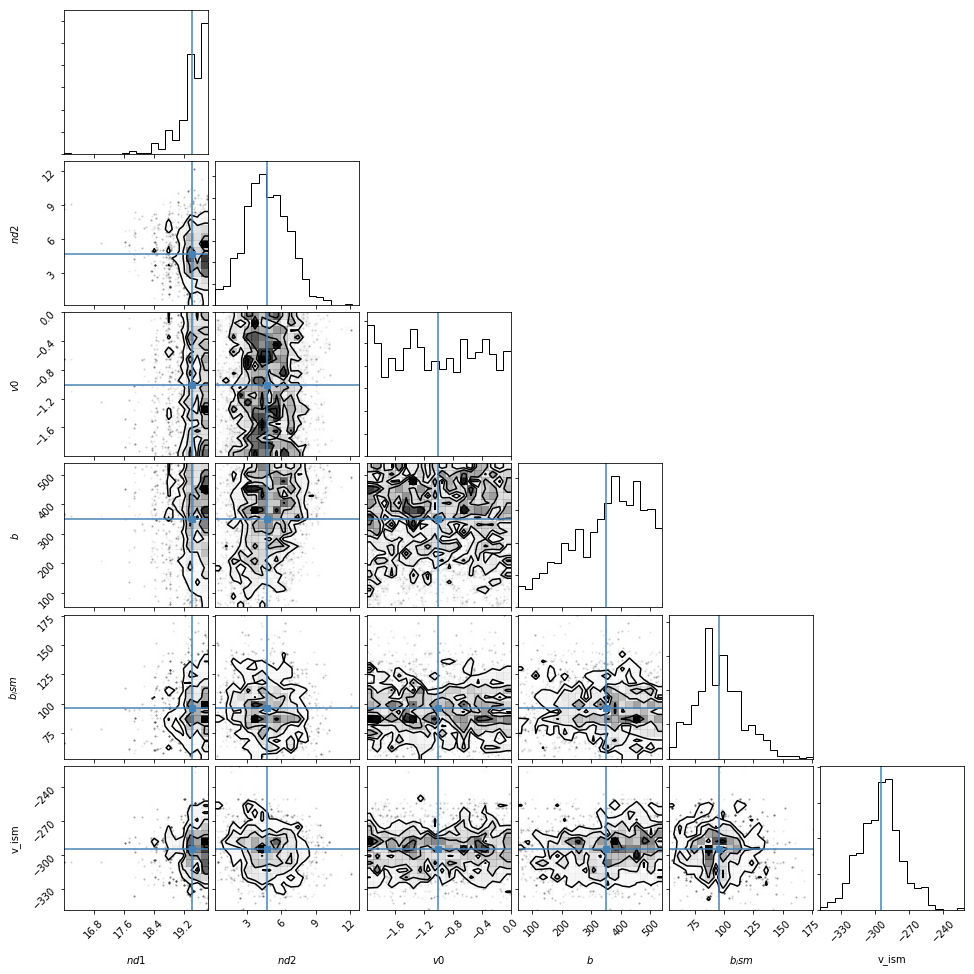

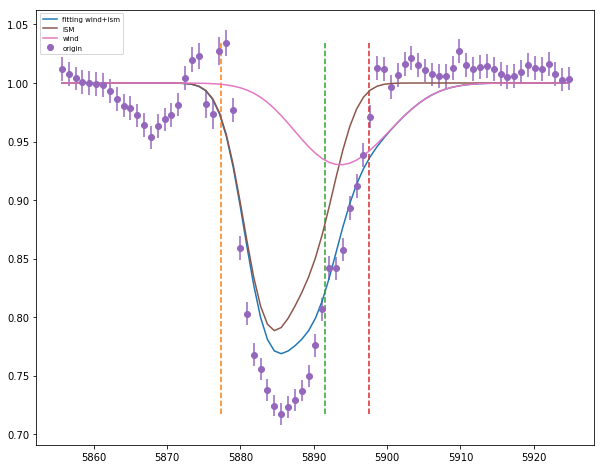

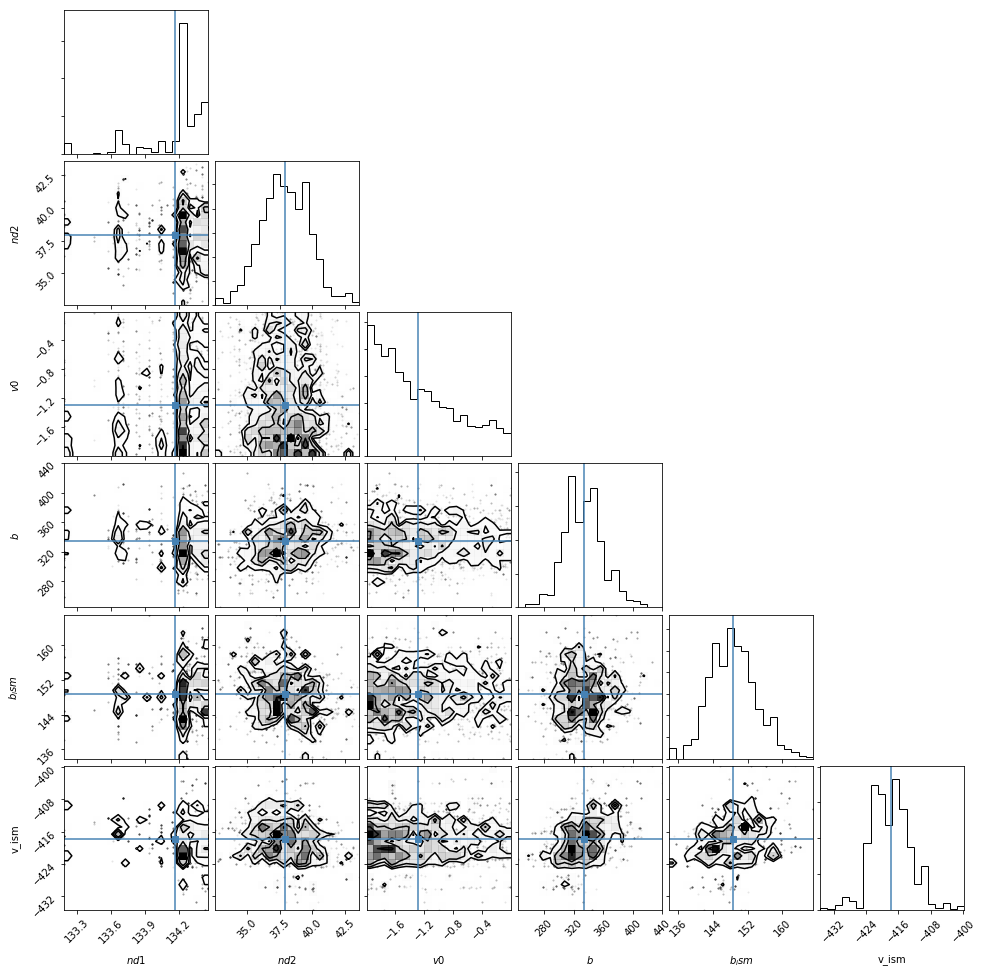

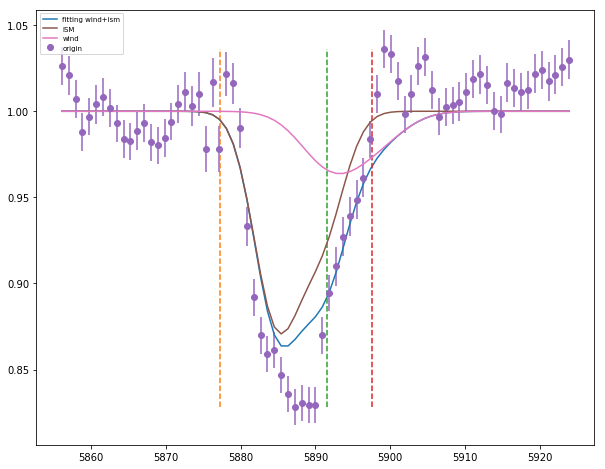

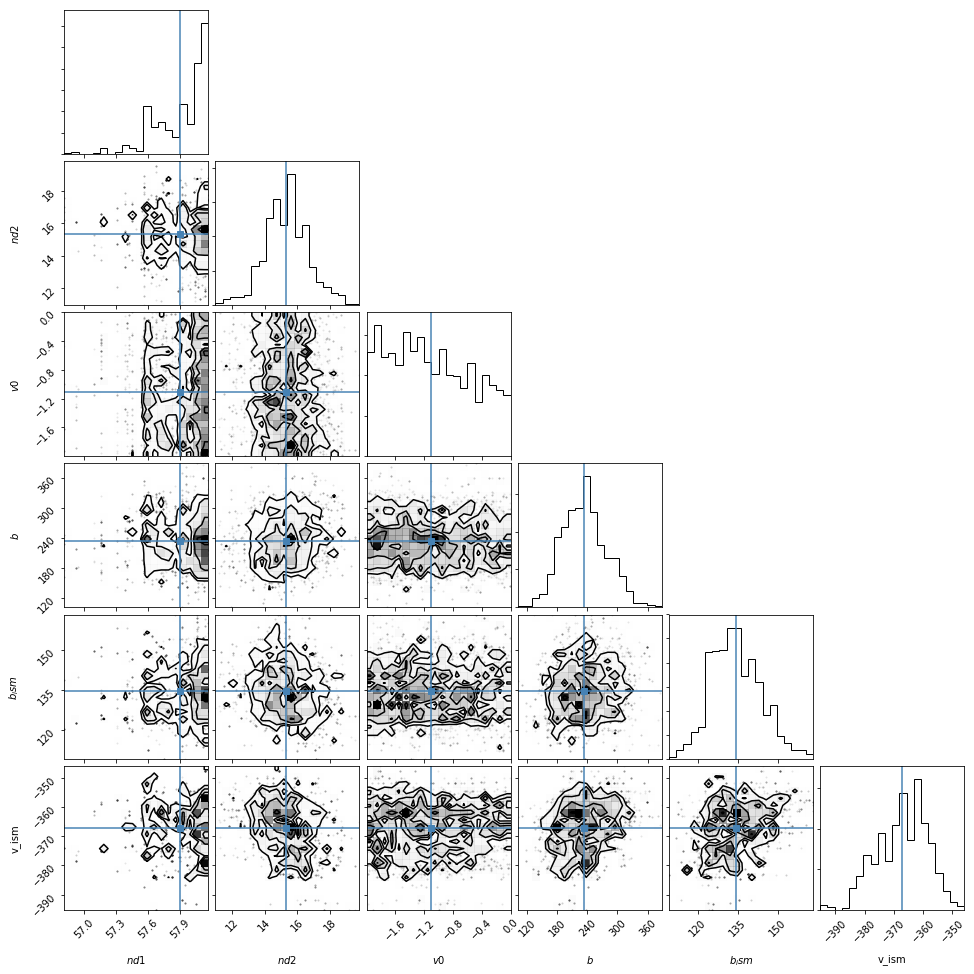

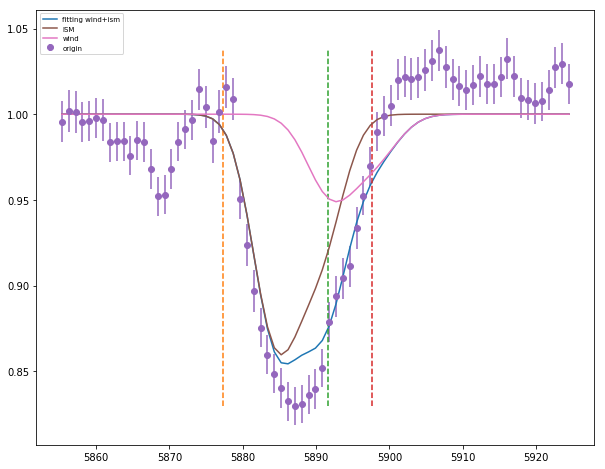

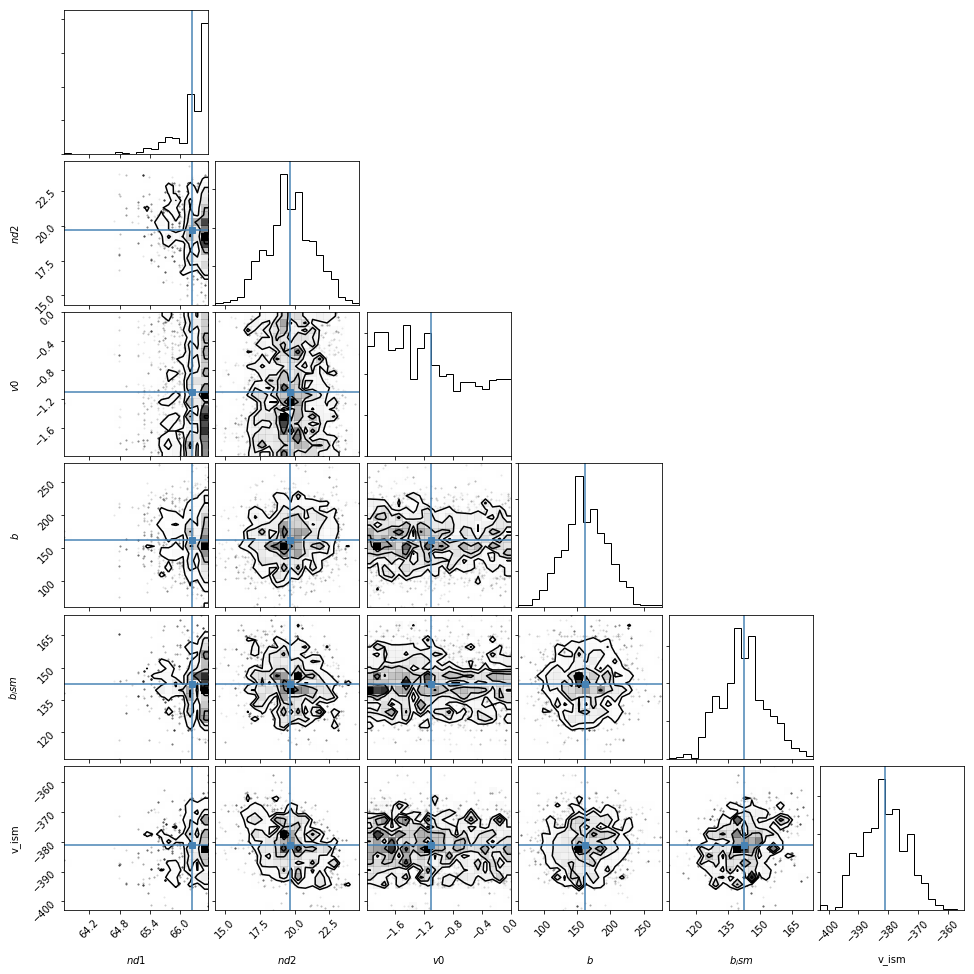

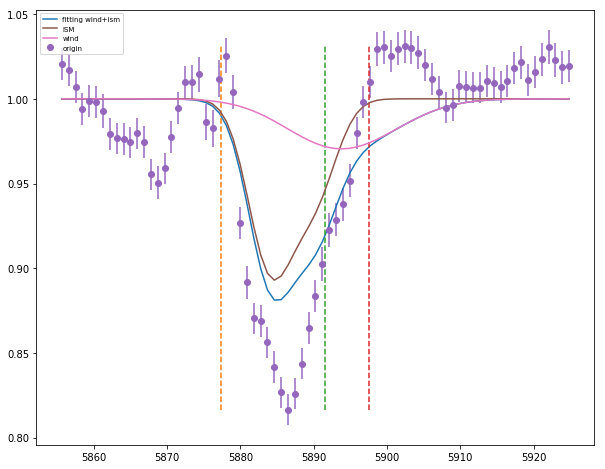

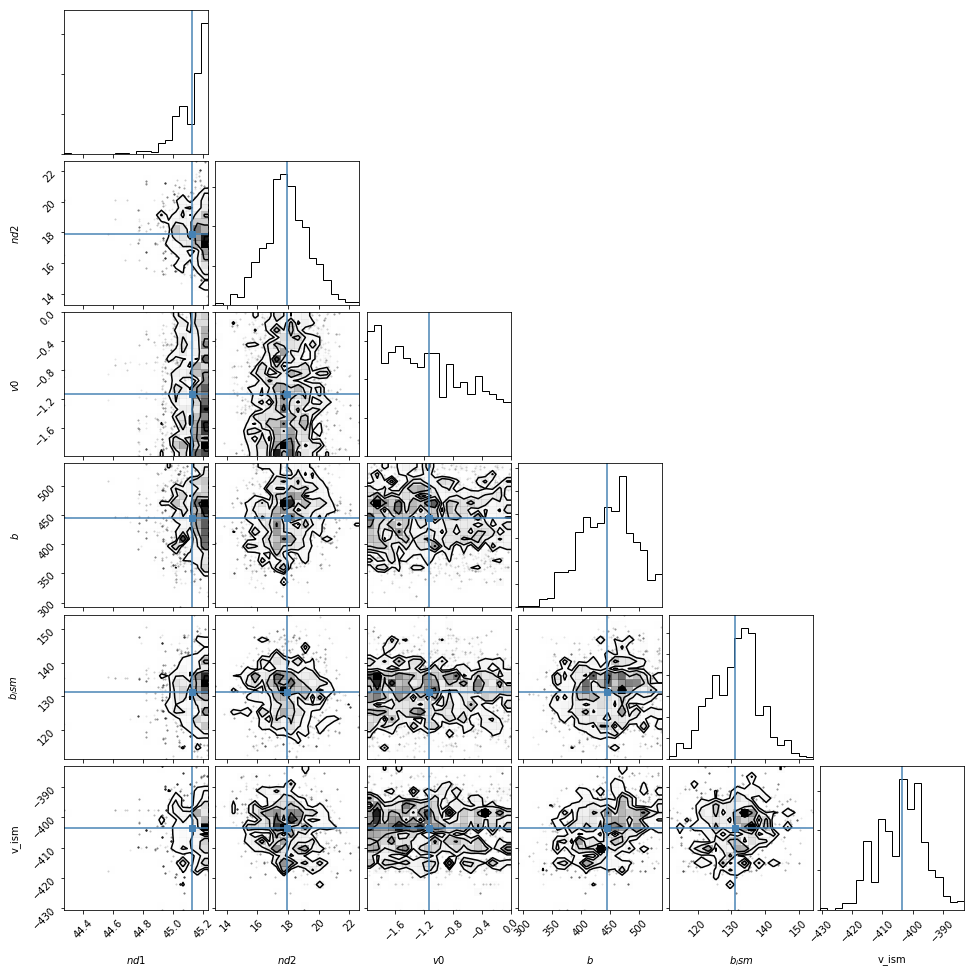

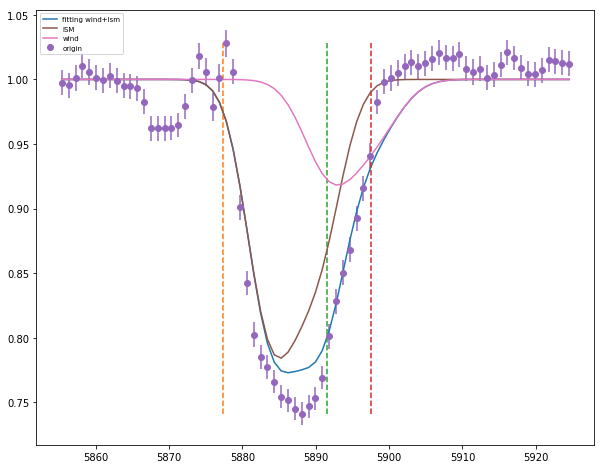

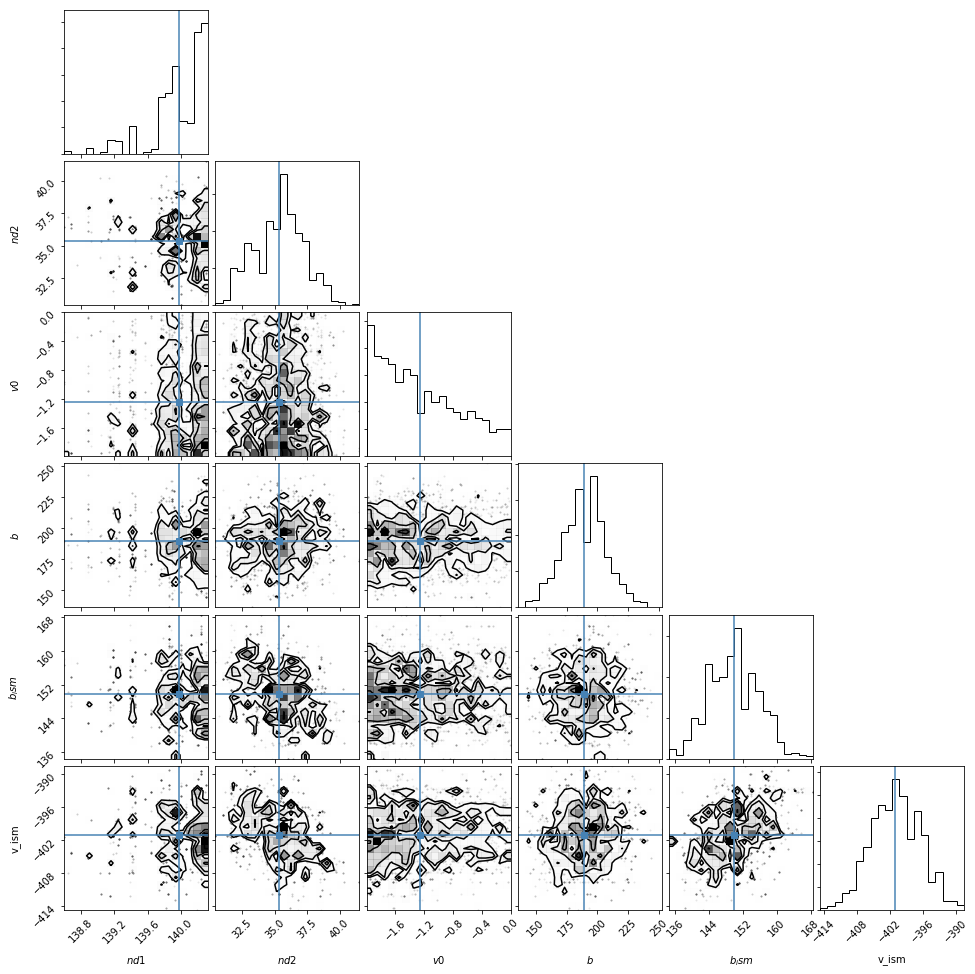

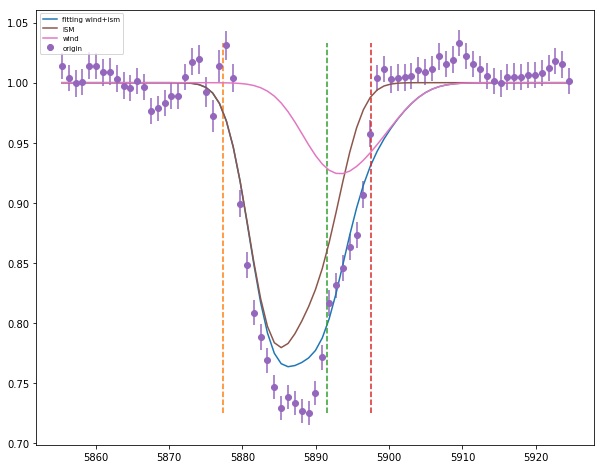

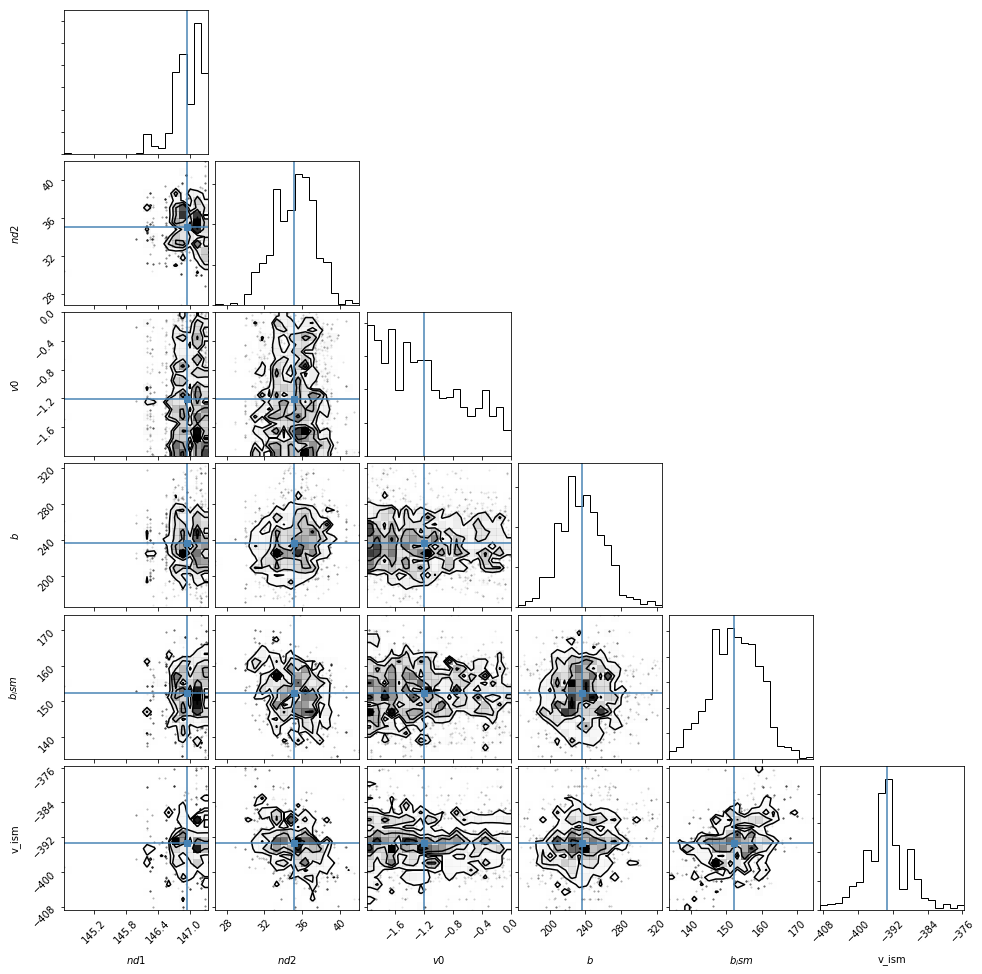

In [10]:
covering = cov1 = cov2 = 0.3
c = 299792.458
lamb1 = 5891.583
lamb2 = 5897.558
gauss = signal.gaussian(60, 2.46)
dr = fits.open('/Users/katerowlands/sas/mangawork/manga/spectro/redux/v2_0_1/drpall-v2_0_1.fits')  #the dir of drpall file
dir = '/data/kate/Outflows/'  #/home/wuxy14/upload/

"""
SNR & EW cutting criteria
"""
def EW(x):
    return 80 / (x - 30) - 80. / 70

"""
Function of ISM absorption
input:wavelength array
parameters:
number density (call it nd1 later)
b_ism:doppler dispersion of ism
velo:velocity
"""
def ISMDG(x, numberdensity, b_ism, velo):
    la1 = lamb1 * (1 + velo / c)
    la2 = lamb2 * (1 + velo / c)
    lratio = lamb2 / lamb1
    tau1 = np.exp(-((x - la1) ** 2) / ((la1 * b_ism / c) ** 2))
    tau2 = np.exp(-((x - la2) ** 2) / ((la2 * b_ism / c) ** 2))
    return 1 - covering * (1 - np.exp(-2 * numberdensity * tau1 / b_ism - lratio * numberdensity * tau2 / b_ism))

"""
Function of WIND absorption
input:wavelength array
parameters:
number density (call it nd2 later)
b:doppler dispersion of wind
velo:velocity
"""
def WINDDG(x, nd, v, b):
    lam1 = lamb1 * (1 + v / c)
    lam2 = lamb2 * (1 + v / c)
    lratio = lamb2 / lamb1
    tau1 = np.exp(-((x - lam1) ** 2) / ((lam1 * b / c) ** 2))
    tau2 = np.exp(-((x - lam2) ** 2) / ((lam2 * b / c) ** 2))
    return 1 - covering * (1 - np.exp(-2 * nd * tau1 / b - lratio * nd * tau2 / b))

"""
Function of NaD absorption line
input:wavelength array
"""
def I(x, nd1, nd2, v, b, b_ism, velo):
    return ISMDG(x, nd1, b_ism, velo) * WINDDG(x, nd2, v, b)

"""
Function of NaD absorption line after convolved by instrumental resolution
input:wavelength array
"""
def Model_I(x, nd1, nd2, v, b, b_ism, velo):
    y = convolve(I(x, nd1, nd2, v, b, b_ism, velo) - 1, gauss, mode='same') / sum(gauss) + 1
    return y

"""
Function of NaD absorption line (but only assume one component)
 after convolved by instrumental resolution
input:wavelength array
"""
def Onecomponent(x, nd1, b_ism, v):
    y = convolve(ISMDG(x, nd1, b_ism, v) - 1, gauss, mode='same') / sum(gauss) + 1
    return y


"""
input:plate number  array & ifu number array
return:sampler of MCMC
"""
def outflows(plate, ifu):
    for i in range(len(plate)):
        print (str(int(plate[i])) + '/' + str(int(ifu[i])))
        already = glob.glob(dir+'plot_drift_refit/' + str(int(plate[i])) + '-' + str(
            int(ifu[i])))#check whether we have already saved the figure
        if len(already) == 0:
            finddap = glob.glob(
                dir+'VOR100/' + str(int(plate[i])) + '/' + str(
                    int(ifu[i])) + '/*LOG*') #read LOG CUBE
            drp = glob.glob(dir+'VOR100/' + str(int(plate[i])) + '/' + str(
                int(ifu[i])) + '/*MAP*') #read MAP
            binnum = np.loadtxt(dir+'' + str(int(plate[i])) + '-' + str(int(ifu[i])) + '.txt')#this file saves the qualified bin number
            result = creat(finddap[0], drp[0], binnum)

    return result

"""
use MCMC to fit NaD line profile
and save the plots of fitting result & parameter correlation
input:dir of dap and drp ; array of qualified(or what we think have wind) bins
"""
def creat(finddap, drp, binnum):
    target = fits.open(drp)
    vel_map = fits.open(finddap)
    corr = vel_map[5].data
    binmap = target[6].data
    vel = target[15].data
    z = dr[1].data['nsa_z'][np.where((dr[1].data['plateifu'] == drp.split('/')[-3] + '-' + drp.split('/')[-2]))]
    continuum = vel_map[6].data - vel_map[7].data - vel_map[8].data
    spectrumflux = vel_map[1].data
    inver = vel_map[2].data

    """
    this part creat arraies to save fitting result ##not used in this code cause we don't save velocity maps now
    """
    shap = len(vel)
    v_map = np.zeros((shap, shap), float)
    v_map1 = np.zeros((shap, shap), float)  ##two component wind velocity map
    v_map2 = np.zeros((shap, shap), float)  ##only ISM velocity map
    systmetic_v = np.zeros((shap, shap), float)
    snr_map = np.zeros((shap, shap), float)
    chimap1 = np.zeros((shap, shap), float)
    chimap2 = np.zeros((shap, shap), float)
    redchi1 = np.zeros((shap, shap), float)
    redchi2 = np.zeros((shap, shap), float)
    systmetic_v[np.where(v_map == 0)] = np.nan
    v_map2[np.where(v_map == 0)] = np.nan
    snr_map[np.where(v_map == 0)] = np.nan
    chimap1[np.where(v_map == 0)] = np.nan
    chimap2[np.where(v_map == 0)] = np.nan
    redchi1[np.where(v_map == 0)] = np.nan
    redchi2[np.where(v_map == 0)] = np.nan
    v_map1[np.where(v_map == 0)] = np.nan
    v_map[np.where(v_map == 0)] = np.nan

    """
    EM & SNR cutting qualified bins ##not used in this code since we have already choose some spaxels by eye
    """
    #ew = fits.open(
    #    dir+'EW/' + drp.split('/')[-3] + '-' + drp.split('/')[-2] + '.fits')
    eqw = snr_map.copy()
    eqw = 10. #ew[0].data
    err_eqw = np.zeros((shap, shap), float) #ew[1].data
    snr_eqw = np.zeros((shap, shap), float) #ew[2].data
    snr_eqw = 100.
    binmap[np.where(snr_eqw == 0)] = -1
    binmap[np.where((snr_eqw < 100) & (eqw < EW(snr_eqw)))] = -1
    binmap[np.where(np.abs(eqw) < 3 * err_eqw)] = -1

    for bins in binnum:

        try:
            target = fits.open(drp)
            binmap = target[6].data
            locate = np.where(binmap == bins)
            spaxadd = spectrumflux[:, locate[0][0], locate[1][0]]
        except:
            print('Error!!!')
            continue
        continuumadd = continuum[:, locate[0][0], locate[1][0]]
        inve = inver[:, locate[0][0], locate[1][0]]
        v_pecu = vel[np.where(binmap == bins)][0]
        v_obs = c * np.log((1 + z) * (1 + v_pecu / c))
        wavelength = np.exp(np.log(vel_map[4].data) - v_obs / c)
        flux = spaxadd * corr
        continuumadd = continuumadd * corr
        norm = np.mean(continuumadd[np.where((wavelength > 5445) & (wavelength < 5550))])
        if norm == 0:
            v_map[np.where(binmap == bins)] = np.nan
            v_map1[np.where(binmap == bins)] = np.nan
            chimap1[np.where(binmap == bins)] = np.nan
            chimap2[np.where(binmap == bins)] = np.nan
            redchi1[np.where(binmap == bins)] = np.nan
            redchi2[np.where(binmap == bins)] = np.nan
        else:
            fluxerror = np.sqrt(inve * (norm ** 2))
            stellar_continuum = continuumadd / norm
            flux = flux / norm
            naloc = np.where((wavelength > 5855) & (wavelength < 5925))
            plt.figure(figsize=(10, 8))
            flux = flux[naloc]
            stellar_continuum = stellar_continuum[naloc]
            renormalization = flux / stellar_continuum
            fluxerror = fluxerror[naloc]
            error = fluxerror * stellar_continuum
            wavelength = wavelength[naloc]
            """
            interpolate wavelength and other array to get more points; number of points from about 36 to 75
            """
            f = interpolate.interp1d(wavelength, renormalization)
            g = interpolate.interp1d(renormalization, error)
            h = interpolate.interp1d(wavelength, stellar_continuum)
            wavelength = np.linspace(np.min(wavelength), np.max(wavelength), num=75)
            flux_fit = f(wavelength)
            flux_error = g(flux_fit)

            """
            fitting He line and subtract it
            """
            def He(x, amp, sigma, center):
                return 1 + amp * np.exp(-((x - center) ** 2) / (2 * sigma ** 2))

            he = Model(He)
            par_he = he.make_params()
            par_he.add('amp', value=0.4, min=0, max=2)
            par_he.add('center', value=5877.3, min=5822.3, max=5877.3 + 50)  ###??so large range??
            par_he.add('sigma', value=0.5, min=0, max=500)
            he_output = he.fit(flux_fit[np.where((wavelength > 5860) & (wavelength < 5895))], par_he,
                               x=wavelength[np.where((wavelength > 5860) & (wavelength < 5895))],
                               weights=flux_error[np.where((wavelength > 5860) & (wavelength < 5895))])

            fluxfit = flux_fit + 1 - He(wavelength, he_output.best_values['amp'], he_output.best_values['sigma'],
                                        he_output.best_values['center'])

            """
            use onecomponent line profile to get a rough value of Nd1,Nd2
            """
            comparation = Model(Onecomponent)  ##one component function
            par_one = comparation.make_params()
            par_one.add('nd1', value=20, min=1, max=400)
            par_one.add('v', value=0, min=-200, max=0)
            par_one.add('b_ism', value=100, min=20, max=300)
            # fit one component model
            result2 = comparation.fit(fluxfit, par_one, x=wavelength, weights=flux_error,
                                      method='leastsqr', scale_covar=True)  # fit one component model

            """
            use Model_I (two component model) to build fitting model and use MCMC to fit the data
            """
            #create model and give each parameters its limit and short name
            intensity_fitter = pyspeckit.models.model.SpectralModel(Model_I, 6,
                                                                    parnames=['nd1', 'nd2', 'v', 'b', 'b_ism', 'velo'],
                                                                    parlimited=[(True, True), (True, True),
                                                                                (True, True), (True, True),
                                                                                (True, True), (True, True)],
                                                                    parlimits=[(0, result2.best_values['nd1']),
                                                                               (0, result2.best_values['nd1']),
                                                                               (-2, 0), (50, 540), (50, 540),
                                                                               (-500, 0)],
                                                                    shortvarnames=(
                                                                    'nd1', 'nd2', 'v', 'b', 'b_ism', 'velo'),
                                                                    )
            #build spectrum
            sp = pyspeckit.Spectrum(data=fluxfit, xarr=wavelength, error=1 / flux_error)
            #register fitter use the model we have bulit
            sp.specfit.register_fitter(name='Intensity', function=intensity_fitter, npars=6)
            #fit the spectrum; use the result of one-component fitting to give the guess of Nd1&Nd2
            sp.specfit(fittype='Intensity',
                       guesses=[result2.best_values['nd1'] / 2, result2.best_values['nd1'] / 2, 0, 60, 60, 0])
            #use MCMC to fit and get error
            MCwithpriors = sp.specfit.fitter.get_pymc(sp.xarr, sp.data, sp.error, use_fitted_values=True)
            MCwithpriors.sample(5000, burn=500)

            """
            use mean value of each quantities as result and plot NaD origin points & fitting result
            """
            plt.plot(wavelength, Model_I(wavelength, MCwithpriors.ND0.stats()['mean'], MCwithpriors.ND1.stats()['mean'],
                                         MCwithpriors.V0.stats()['mean'],
                                         MCwithpriors.B0.stats()['mean'], MCwithpriors.B_ISM0.stats()['mean'],
                                         MCwithpriors.VELO0.stats()['mean']), label='fitting wind+ism')
            plt.plot([5877.3, 5877.3], [np.min(fluxfit), np.max(fluxfit)], '--')
            plt.plot([lamb1, lamb1], [np.min(fluxfit), np.max(fluxfit)], '--')
            plt.plot([lamb2, lamb2], [np.min(fluxfit), np.max(fluxfit)], '--')
            plt.errorbar(wavelength, fluxfit, yerr=1 / flux_error, fmt='o', label='origin')
            ISM = -convolve(1 - ISMDG(wavelength, MCwithpriors.ND0.stats()['mean'],
                                      MCwithpriors.B_ISM0.stats()['mean'], MCwithpriors.VELO0.stats()['mean']), gauss,
                            mode='same') / sum(gauss) + 1
            Wind = -convolve(1 - WINDDG(wavelength, MCwithpriors.ND1.stats()['mean'],
                                        MCwithpriors.V0.stats()['mean'], MCwithpriors.B0.stats()['mean']), gauss,
                             mode='same') / sum(gauss) + 1
            plt.plot(wavelength, ISM, label='ISM')
            plt.plot(wavelength, Wind, label='wind')
            plt.legend(loc='upper left', fontsize=7)
            plt.savefig(
                dir+'' + drp.split('/')[-3] + '-' + drp.split('/')[-2] + '_mcmc_' + str(bins) + '.png')

            """
            plot correlation of each quantities
            """
            sp2 = []
            sp2.append(MCwithpriors.ND0.trace())
            sp2.append(MCwithpriors.ND1.trace())
            sp2.append(MCwithpriors.V0.trace())
            sp2.append(MCwithpriors.B0.trace())
            sp2.append(MCwithpriors.B_ISM0.trace())
            sp2.append(MCwithpriors.VELO0.trace())
            sp2 = np.array(sp2)
            fig = corner.corner(sp2.T, labels=["$nd1$", "$nd2$", "$v0$", "$b$", "$b_ism$", "v_ism"],
                                truths=[MCwithpriors.ND0.stats()['mean'], MCwithpriors.ND1.stats()['mean'], MCwithpriors.V0.stats()['mean'],
                                        MCwithpriors.B0.stats()['mean']
                                    , MCwithpriors.B_ISM0.stats()['mean'], MCwithpriors.VELO0.stats()['mean']])
            fig.savefig(dir+'' + drp.split('/')[-3] + '-' + drp.split('/')[-2] + '_correlation_' + str(
                bins) + '.png')


            """
            save the 95%HPD interval,mean value,mcmc error and standard deviation of each quantities
            """
            sp1=MCwithpriors
            newfits = fits.HDUList()
            newfits.append(fits.ImageHDU(
                [sp1.ND0.stats()['95% HPD interval'][0], sp1.ND0.stats()['95% HPD interval'][1],
                 sp1.ND0.stats()['mean'],
                 sp1.ND0.stats()['mc error'], sp1.ND0.stats()['standard deviation']], name='ND1'))
            newfits.append(fits.ImageHDU(
                [sp1.ND1.stats()['95% HPD interval'][0], sp1.ND1.stats()['95% HPD interval'][1],
                 sp1.ND1.stats()['mean'],
                 sp1.ND1.stats()['mc error'], sp1.ND1.stats()['standard deviation']], name='ND2'))
            newfits.append(fits.ImageHDU(
                [sp1.B0.stats()['95% HPD interval'][0], sp1.B0.stats()['95% HPD interval'][1], sp1.B0.stats()['mean'],
                 sp1.B0.stats()['mc error'], sp1.B0.stats()['standard deviation']], name='b'))
            newfits.append(fits.ImageHDU(
                [sp1.B_ISM0.stats()['95% HPD interval'][0], sp1.B_ISM0.stats()['95% HPD interval'][1],
                 sp1.B_ISM0.stats()['mean'],
                 sp1.B_ISM0.stats()['mc error'], sp1.B_ISM0.stats()['standard deviation']], name='b_ism'))
            newfits.append(fits.ImageHDU(
                [sp1.V0.stats()['95% HPD interval'][0], sp1.V0.stats()['95% HPD interval'][1], sp1.V0.stats()['mean'],
                 sp1.V0.stats()['mc error'], sp1.V0.stats()['standard deviation']], name='wind velocity'))
            newfits.append(fits.ImageHDU(
                [sp1.VELO0.stats()['95% HPD interval'][0], sp1.VELO0.stats()['95% HPD interval'][1],
                 sp1.VELO0.stats()['mean'],
                 sp1.VELO0.stats()['mc error'], sp1.VELO0.stats()['standard deviation']], name='ISM velocity'))
            newfits.writeto(dir+'' + drp.split('/')[-3] + '-' + drp.split('/')[-2] + str(bins)+'.fits')

    return MCwithpriors

plate=['7443']
ifu=['12703']
outflows(plate,ifu)